In [129]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers as opt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import losses
import pandas as pd

In [130]:
DATA_PATH="./Vowel_Data/Formant/"

In [131]:
seed=42

In [132]:
def get_formant(file_path):
    formant=pd.read_csv(file_path,
                delim_whitespace=True,
                header=None,
                names=["time","F1","F2","F3","F4","F5"],
                dtype=np.float64,
                na_values="--undefined--")
    return formant

def get_all_formants(path=DATA_PATH):
    labels=labels=sorted(os.listdir(path))
    all_formant=pd.DataFrame() #empty dataframe to store all_formants
    
    for label_index,label in enumerate(labels):
        folder_formant=pd.DataFrame() #empty dataframe to store formants of indivuals vowels/words i.e. folders

        formant_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(formant_files,"Reading Formants of label -'{}'".format(label)):
            #print(file)
            individual_formant=get_formant(file_path=file)
  
            length=len(individual_formant)
            F_i=individual_formant.loc[2:,'F1':'F5'].values
            F_i1=individual_formant.loc[1:length-2,'F1':'F5'].values
            F_i2=individual_formant.loc[:length-3,'F1':'F5'].values
            assert len(F_i)==len(F_i1)==len(F_i2)
            individual_formant.loc[2:,['F1_diff2','F2_diff2','F3_diff2','F4_diff2','F5_diff2']]=F_i-2*F_i1+F_i2
            
            individual_formant=individual_formant.dropna()   #drop the first two rows as there are NaN values due to the difference
            
            folder_formant=folder_formant.append(individual_formant,ignore_index=True)
        
        folder_formant['disp(F5-F1)']=folder_formant['F5']-folder_formant['F1']
        folder_formant['disp(F4-F3)']=folder_formant['F4']-folder_formant['F3']
        folder_formant['disp(F5-F3)']=folder_formant['F5']-folder_formant['F3']
        folder_formant['disp(F5-F4)']=folder_formant['F5']-folder_formant['F4']
        
        folder_formant['label']=label_index  #new columns for encoding label
        
        all_formant=all_formant.append(folder_formant,ignore_index=True)     
    return all_formant

def get_train_test(split_ratio=0.8,random_state=42):
    all_formants=get_all_formants()
    
    y=all_formants['label'].values
 
    only_formants=all_formants.drop(labels=['time','label'],axis=1)
    
    standard_formants=(only_formants-only_formants.mean())/only_formants.std()
    
    X=standard_formants.values   

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [133]:
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Formants of label -'Formant7': 100%|██████████| 40/40 [00:00<00:00, 130.76it/s]


In [134]:
np.random.seed(seed)

In [135]:
model_v=Sequential()
#model_v.add(Dense(128, activation='relu', input_shape=(6,)))
#model_v.add(Dense(64, activation='relu'))
model_v.add(Dense(32, activation='tanh',input_shape=(X_train.shape[1],)))
model_v.add(Dense(16, activation='tanh'))
model_v.add(Dense(7, activation='softmax'))

In [136]:
model_v.compile(
    optimizer=opt.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['AUC']#,
    #metrics=[['accuracy','AUC']]
)

In [137]:
history_v=model_v.fit(X_train, y_train_hot, epochs=50, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/50
1/1 [==============================] - 0s 306ms/step - loss: 2.2004 - auc: 0.4022 - val_loss: 2.1155 - val_auc: 0.4362
Epoch 2/50
1/1 [==============================] - 0s 78ms/step - loss: 2.1126 - auc: 0.4366 - val_loss: 2.0383 - val_auc: 0.4771
Epoch 3/50
1/1 [==============================] - 0s 70ms/step - loss: 2.0343 - auc: 0.4797 - val_loss: 1.9701 - val_auc: 0.5277
Epoch 4/50
1/1 [==============================] - 0s 71ms/step - loss: 1.9653 - auc: 0.5323 - val_loss: 1.9101 - val_auc: 0.5829
Epoch 5/50
1/1 [==============================] - 0s 74ms/step - loss: 1.9044 - auc: 0.5896 - val_loss: 1.8569 - val_auc: 0.6380
Epoch 6/50
1/1 [==============================] - 0s 80ms/step - loss: 1.8507 - auc: 0.6457 - val_loss: 1.8094 - val_auc: 0.6836
Epoch 7/50
1/1 [==============================] - 0s 79ms/step - loss: 1.8027 - auc: 0.6910 - val_loss: 1.7666 - val_auc: 0.7177
Epoch 8/50
1/1 [==============================] - 0s 63ms/step - loss: 1.7594 - auc: 0.7242 - va

In [138]:
history_dict_v=history_v.history

loss_v=history_dict_v['loss']
val_loss_v=history_dict_v['val_loss']

auc_v=history_dict_v['auc']
val_auc_v=history_dict_v['val_auc']

In [139]:
epochs=range(1,len(loss_v)+1)
ticks=[1]
ticks2=[i for i in range(5,len(loss_v)+1,5)]
ticks.extend(ticks2)

In [140]:
save_specifier='standard_formants_32_16_tanh_softmax_adam_005_batchfull_seed42'

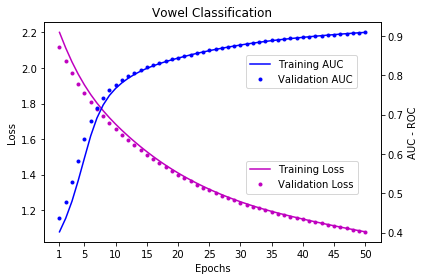

In [154]:
fig, ax=plt.subplots()
ln1=ax.plot(epochs,loss_v,'m', label='Training Loss')
ln2=ax.plot(epochs,val_loss_v,'m.', label='Validation Loss')

ax2=ax.twinx()
ln3=ax2.plot(epochs,auc_v,'b', label='Training AUC')
ln3=ax2.plot(epochs,val_auc_v,'b.', label='Validation AUC')

ax.set_title('Vowel Classification')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax2.set_ylabel('AUC - ROC')

plt.xticks(ticks)
ax.legend(loc=(0.6,0.22))
ax2.legend(loc=(0.6,0.7))
#fig.legend(loc=(0.6,0.4))
plt.tight_layout()
plt.savefig('./New_without_CNN/loss_auc_vowel_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [142]:
DATA_PATH="./Word_Data/Formant/"

In [143]:
def get_formant(file_path):
    formant=pd.read_csv(file_path,
                delim_whitespace=True,
                header=None,
                names=["time","F1","F2","F3","F4","F5"],
                dtype=np.float64,
                na_values="--undefined--")
    return formant

def get_all_formants(path=DATA_PATH):
    labels=labels=sorted(os.listdir(path))
    all_formant=pd.DataFrame() #empty dataframe to store all_formants
    
    for label_index,label in enumerate(labels):
        folder_formant=pd.DataFrame() #empty dataframe to store formants of indivuals vowels/words i.e. folders

        formant_files=[path + label + '/' + file for file in sorted(os.listdir(path+'/'+label))]
        for file in tqdm(formant_files,"Reading Formants of label -'{}'".format(label)):
            #print(file)
            individual_formant=get_formant(file_path=file)
  
            length=len(individual_formant)
            F_i=individual_formant.loc[2:,'F1':'F5'].values
            F_i1=individual_formant.loc[1:length-2,'F1':'F5'].values
            F_i2=individual_formant.loc[:length-3,'F1':'F5'].values
            assert len(F_i)==len(F_i1)==len(F_i2)
            individual_formant.loc[2:,['F1_diff2','F2_diff2','F3_diff2','F4_diff2','F5_diff2']]=F_i-2*F_i1+F_i2
            
            individual_formant=individual_formant.dropna()   #drop the first two rows as there are NaN values due to the difference
            
            folder_formant=folder_formant.append(individual_formant,ignore_index=True)
        
        folder_formant['disp(F5-F1)']=folder_formant['F5']-folder_formant['F1']
        folder_formant['disp(F4-F3)']=folder_formant['F4']-folder_formant['F3']
        folder_formant['disp(F5-F3)']=folder_formant['F5']-folder_formant['F3']
        folder_formant['disp(F5-F4)']=folder_formant['F5']-folder_formant['F4']
        
        folder_formant['label']=label_index  #new columns for encoding label
        
        all_formant=all_formant.append(folder_formant,ignore_index=True)     
    return all_formant

def get_train_test(split_ratio=0.8,random_state=42):
    all_formants=get_all_formants()
    
    y=all_formants['label'].values
 
    only_formants=all_formants.drop(labels=['time','label'],axis=1)
    
    standard_formants=(only_formants-only_formants.mean())/only_formants.std()
    
    X=standard_formants.values   

    assert X.shape[0] == len(y)
    return train_test_split(X,y,test_size=(1-split_ratio),random_state=random_state,shuffle=True,stratify=y)

In [144]:
np.random.seed(seed)
X_train, X_test, y_train, y_test=get_train_test()
y_train_hot=to_categorical(y_train)
y_test_hot=to_categorical(y_test)

Reading Formants of label -'Formant7': 100%|██████████| 40/40 [00:00<00:00, 135.65it/s]


In [145]:
model_w=Sequential()
#model_w.add(Dense(128, activation='tanh', input_shape=(6,)))
#model_w.add(Dense(64, activation='tanh'))
model_w.add(Dense(32, activation='tanh',input_shape=(X_train.shape[1],)))
model_w.add(Dense(16, activation='tanh'))
model_w.add(Dense(7, activation='softmax'))

In [146]:
model_w.compile(
    optimizer=opt.Adam(learning_rate=0.005),
    loss='categorical_crossentropy',
    metrics=['AUC']#,
    #metrics=[['accuracy','AUC']]
)

In [147]:
history_w=model_w.fit(X_train, y_train_hot, epochs=50, batch_size=X_train.shape[0], validation_data=(X_test,y_test_hot))

Epoch 1/50
1/1 [==============================] - 0s 320ms/step - loss: 2.0678 - auc: 0.4771 - val_loss: 2.0104 - val_auc: 0.5050
Epoch 2/50
1/1 [==============================] - 0s 85ms/step - loss: 2.0148 - auc: 0.5015 - val_loss: 1.9671 - val_auc: 0.5364
Epoch 3/50
1/1 [==============================] - 0s 88ms/step - loss: 1.9703 - auc: 0.5341 - val_loss: 1.9318 - val_auc: 0.5702
Epoch 4/50
1/1 [==============================] - 0s 85ms/step - loss: 1.9337 - auc: 0.5691 - val_loss: 1.9030 - val_auc: 0.5987
Epoch 5/50
1/1 [==============================] - 0s 87ms/step - loss: 1.9037 - auc: 0.6000 - val_loss: 1.8794 - val_auc: 0.6220
Epoch 6/50
1/1 [==============================] - 0s 77ms/step - loss: 1.8788 - auc: 0.6245 - val_loss: 1.8596 - val_auc: 0.6394
Epoch 7/50
1/1 [==============================] - 0s 79ms/step - loss: 1.8578 - auc: 0.6432 - val_loss: 1.8425 - val_auc: 0.6521
Epoch 8/50
1/1 [==============================] - 0s 80ms/step - loss: 1.8398 - auc: 0.6571 - va

In [148]:
history_dict_w=history_w.history
loss_w=history_dict_w['loss']
val_loss_w=history_dict_w['val_loss']

auc_w=history_dict_w['auc']
val_auc_w=history_dict_w['val_auc']

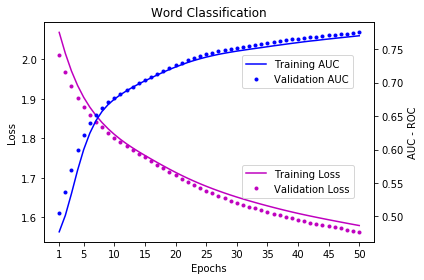

In [153]:
fig, ax=plt.subplots()
ln1=ax.plot(epochs,loss_w,'m', label='Training Loss')
ln2=ax.plot(epochs,val_loss_w,'m.', label='Validation Loss')

ax2=ax.twinx()
ln3=ax2.plot(epochs,auc_w,'b', label='Training AUC')
ln3=ax2.plot(epochs,val_auc_w,'b.', label='Validation AUC')

ax.set_title('Word Classification')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax2.set_ylabel('AUC - ROC')

plt.xticks(ticks)
ax.legend(loc=(0.6,0.2))
ax2.legend(loc=(0.6,0.7))
#fig.legend(loc=(0.6,0.4))
plt.tight_layout()
plt.savefig('./New_without_CNN/loss_auc_word_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [150]:
#COMPARE

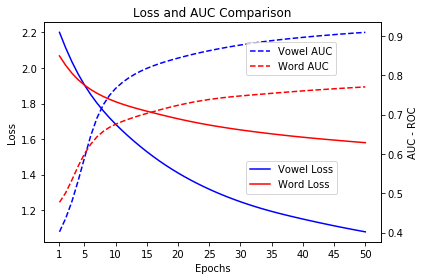

In [152]:
fig, ax=plt.subplots()
ln1=ax.plot(epochs,loss_v,'b', label='Vowel Loss')
ln2=ax.plot(epochs,loss_w,'r', label='Word Loss')

ax2=ax.twinx()
ln3=ax2.plot(epochs,auc_v,'b--', label='Vowel AUC')
ln3=ax2.plot(epochs,auc_w,'r--', label='Word AUC')

ax.set_title('Loss and AUC Comparison')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax2.set_ylabel('AUC - ROC')

plt.xticks(ticks)
ax.legend(loc=(0.6,0.22))
ax2.legend(loc=(0.6,0.76))
#fig.legend(loc=(0.6,0.4))
plt.tight_layout()
plt.savefig('./New_without_CNN/comare_'+save_specifier+'.pdf',format='pdf', dpi=600)

In [106]:
all_compare_df=pd.DataFrame({'loss_v':loss_v,
                      'val_loss_v':val_loss_v,
                      'auc_v':auc_v,
                      'val_auc_v':val_auc_v,
                      'loss_w':loss_w,
                      'val_loss_w':val_loss_w,
                      'auc_w':auc_w,
                      'val_auc_w':val_auc_w
                     })

all_compare_df.to_csv('./New_without_CNN/all_compare_data_'+save_specifier+'.csv')

In [144]:
all_compare_df.tail()

,loss_v,val_loss_v,acc_v,val_acc_v,auc_v,val_auc_v,loss_w,val_loss_w,acc_w,val_acc_w,auc_w,val_auc_w
45,1.510234,1.498732,0.366437,0.370279,0.796772,0.800146,1.708708,1.714930,0.303956,0.299898,0.720853,0.715563
46,1.504479,1.498546,0.365201,0.367102,0.797813,0.798793,1.707437,1.713586,0.305353,0.300660,0.721409,0.716229
47,1.500465,1.493217,0.364848,0.376633,0.798146,0.801928,1.706840,1.713536,0.305924,0.298121,0.721904,0.715366
48,1.497878,1.487364,0.368114,0.381221,0.799064,0.803229,1.704514,1.714414,0.304591,0.297613,0.721866,0.713816
49,1.493867,1.477454,0.372881,0.384045,0.799755,0.805838,1.703115,1.715560,0.304019,0.295328,0.721080,0.712323


In [40]:
all_compare_df.tail()

,loss_v,val_loss_v,acc_v,val_acc_v,auc_v,val_auc_v,loss_w,val_loss_w,acc_w,val_acc_w,auc_w,val_auc_w
45,1.411883,1.405710,0.447034,0.461701,0.833349,0.836040,1.781247,1.795952,0.276208,0.262062,0.681543,0.670234
46,1.397944,1.405708,0.465660,0.461701,0.838839,0.836425,1.781183,1.794109,0.273224,0.264093,0.679729,0.671856
47,1.398288,1.398337,0.465749,0.469820,0.838970,0.838291,1.782951,1.789811,0.272017,0.279584,0.678212,0.675529
48,1.396289,1.386209,0.470251,0.492411,0.839035,0.842212,1.780074,1.782680,0.288463,0.283647,0.680309,0.680218
49,1.383023,1.377770,0.486405,0.498412,0.843179,0.843809,1.774793,1.775333,0.290939,0.297359,0.684268,0.684437


In [78]:
all_compare_df.tail()

,loss_v,val_loss_v,acc_v,val_acc_v,auc_v,val_auc_v,loss_w,val_loss_w,acc_w,val_acc_w,auc_w,val_auc_w
45,1.645361,1.635071,0.321140,0.318265,0.761262,0.764530,1.794142,1.795046,0.296517,0.292995,0.686432,0.684662
46,1.628057,1.626682,0.320772,0.325983,0.768138,0.769586,1.791320,1.788053,0.302791,0.312337,0.687685,0.687996
47,1.615787,1.615028,0.326379,0.358692,0.774701,0.773985,1.786905,1.775738,0.318541,0.320178,0.689430,0.694610
48,1.608039,1.607040,0.355607,0.356487,0.777154,0.774983,1.776664,1.769562,0.327103,0.317825,0.694150,0.696794
49,1.598885,1.596370,0.358548,0.360529,0.778704,0.778123,1.770723,1.765198,0.325404,0.308677,0.695664,0.698677


In [90]:
all_compare_df.tail()

,loss_v,val_loss_v,acc_v,val_acc_v,auc_v,val_auc_v,loss_w,val_loss_w,acc_w,val_acc_w,auc_w,val_auc_w
45,1.112686,1.118910,0.612776,0.613377,0.904947,0.902697,1.566870,1.560570,0.371871,0.365395,0.776166,0.776080
46,1.104304,1.110964,0.614798,0.614112,0.906490,0.904161,1.564591,1.558269,0.371610,0.367224,0.776922,0.776914
47,1.096042,1.103127,0.617463,0.615583,0.907929,0.905562,1.562321,1.555987,0.372982,0.368008,0.777572,0.777548
48,1.087889,1.095378,0.619301,0.617420,0.909399,0.906913,1.560057,1.553699,0.374028,0.370883,0.778273,0.778163
49,1.079837,1.087704,0.621507,0.619625,0.910848,0.908233,1.557797,1.551383,0.375270,0.371668,0.778951,0.778717


In [38]:
all_compare_df.tail()

,loss_v,val_loss_v,auc_v,val_auc_v,loss_w,val_loss_w,auc_w,val_auc_w
45,1.128211,1.124779,0.900204,0.900891,1.594647,1.583974,0.765425,0.768485
46,1.119978,1.116775,0.901585,0.902182,1.591982,1.581514,0.766377,0.769388
47,1.111867,1.108886,0.902866,0.903427,1.589316,1.579081,0.767414,0.770433
48,1.103872,1.101110,0.904103,0.904730,1.586650,1.576668,0.768452,0.771224
49,1.095993,1.093450,0.905418,0.905945,1.583980,1.574261,0.769505,0.772125


In [84]:
all_compare_df.tail()

,loss_v,val_loss_v,auc_v,val_auc_v,loss_w,val_loss_w,auc_w,val_auc_w
45,1.199779,1.204454,0.885633,0.883808,1.585439,1.572345,0.769693,0.772715
46,1.192895,1.197729,0.887008,0.885193,1.583040,1.570226,0.770453,0.773373
47,1.186087,1.191058,0.888309,0.886563,1.580672,1.568079,0.771249,0.774063
48,1.179352,1.184426,0.889600,0.887841,1.578331,1.565906,0.771982,0.774777
49,1.172684,1.177817,0.890935,0.889149,1.576013,1.563722,0.772770,0.775490


In [107]:
all_compare_df.tail()

,loss_v,val_loss_v,auc_v,val_auc_v,loss_w,val_loss_w,auc_w,val_auc_w
45,1.587871,1.578000,0.769109,0.771332,1.603054,1.593362,0.761790,0.764004
46,1.585117,1.575239,0.770034,0.772196,1.601045,1.591489,0.762523,0.764766
47,1.582375,1.572474,0.770925,0.773096,1.599065,1.589634,0.763247,0.765487
48,1.579630,1.569696,0.771839,0.774045,1.597106,1.587795,0.763925,0.766144
49,1.576875,1.566909,0.772759,0.775067,1.595161,1.585969,0.764625,0.766711
